In [5]:
import pandas as pd
import numpy as np
import torch
from skimage.io import imread
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [6]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Images
dir = './frames/'

N = 2000
df = pd.DataFrame()
for i in range(N):
    k = i + 1
    imgs = dir + 'seq_' + f'{k:06d}' + '.jpg'
    frame_id = 'seq_' + f'{k:06d}' + '.jpg'
    # print(imgs)
    # Inference
    results = model(imgs)

    # Results
    # results.print()  
    # results.show()  # or .show()

    # Data
    # print(results.xyxy[0])  # print img1 predictions (pixels)
    tf_results = results.xyxy[0].cpu()
    np_results = tf_results.numpy()
    np_results = np_results[np_results[:,5]==0,0:4]
    np_results[:,2] = np_results[:,2] - np_results[:,0]
    np_results[:,3] = np_results[:,3] - np_results[:,1]
    np_results = np_results.astype(int)
    np_results = np_results.astype(str)
    list = ' '.join([' '.join(np_results[i]) for i in range(np_results.shape[0])])
    df2 = pd.DataFrame([[list]], columns=['Predicted'], index=[frame_id])
    df = pd.concat([df,df2])
df.index.names = ['Id']

Using cache found in C:\Users\Beaucour/.cache\torch\hub\ultralytics_yolov5_master
requirements: matplotlib>=3.2.2 not found and is required by YOLOv5, attempting auto-update...
requirements: Command 'pip install 'matplotlib>=3.2.2'' returned non-zero exit status 1.
requirements: seaborn>=0.11.0 not found and is required by YOLOv5, attempting auto-update...
requirements: Command 'pip install 'seaborn>=0.11.0'' returned non-zero exit status 1.
YOLOv5  2022-2-26 torch 1.10.2 CUDA:0 (NVIDIA GeForce GTX 1060, 6144MiB)

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients, 16.5 GFLOPs
Adding AutoShape... 


In [7]:
df

,Predicted
Id,
seq_000001.jpg,434 337 60 141 489 411 55 68 63 170 36 99 119 ...
seq_000002.jpg,388 160 28 88 425 147 37 102 471 253 42 105 54...
seq_000003.jpg,389 216 38 104 272 345 47 134 525 188 31 91 55...
seq_000004.jpg,520 285 42 123 545 128 37 90 212 200 29 65 478...
seq_000005.jpg,214 196 31 69 341 308 47 143 386 324 44 131 55...
...,...
seq_001996.jpg,518 284 56 134 208 103 24 70 95 263 52 128 109...
seq_001997.jpg,519 352 61 127 71 279 57 126 530 109 34 76 255...
seq_001998.jpg,548 427 66 52 494 117 31 78 225 222 35 43 397 ...


In [8]:
df.to_csv('frames.csv')

In [9]:
N = 2000
df_ground_truth = pd.read_csv('./frames.csv')
print('shape = ',df_ground_truth.shape)
df_ground_truth.head()


shape =  (2000, 2)


,Id,Predicted
0,seq_000001.jpg,434 337 60 141 489 411 55 68 63 170 36 99 119 ...
1,seq_000002.jpg,388 160 28 88 425 147 37 102 471 253 42 105 54...
2,seq_000003.jpg,389 216 38 104 272 345 47 134 525 188 31 91 55...
3,seq_000004.jpg,520 285 42 123 545 128 37 90 212 200 29 65 478...
4,seq_000005.jpg,214 196 31 69 341 308 47 143 386 324 44 131 55...


In [10]:
def read_frame(solution, frame):
    """Read frames and create integer frame_id-s"""
    # file_path = solution[solution.index == frame]['frame_id'].values[0]
    file_path = solution[solution.index == frame]['Id'].values[0]
    return imread('frames/' + file_path)

def annotations_for_frame(solution, frame):
    assert frame in solution.index
    bbs = solution[solution.index == frame].Predicted.values[0]
    if pd.isna(bbs): # some frames contain no vehicles
        return []
    bbs = [int(x) for x in bbs.split(' ')]
    return np.array_split(bbs, len(bbs) / 4)


def show_annotation(solution, frame):
    img = read_frame(solution, frame)
    bbs = annotations_for_frame(solution, frame)
    fig, ax = plt.subplots(figsize=(10, 8))
    for x, y, dx, dy in bbs:
        rect = patches.Rectangle((x, y), dx, dy, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img)
    ax.set_title('Annotations for frame {}.'.format(frame))
    ax.axis('off')
    

interactive(children=(IntSlider(value=1, description='frame_id', max=2000, min=1), Output()), _dom_classes=('w…

<function __main__.f_display(frame_id)>

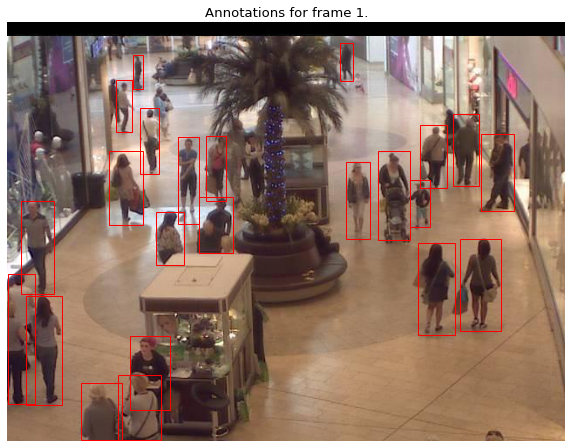

In [11]:
from ipywidgets import interact, widgets
from IPython.display import display

def f_display(frame_id):
    show_annotation(df_ground_truth, frame_id)


interact(f_display, frame_id=widgets.IntSlider(min=1, max=N, step=1, value=1))